# On Track: A Deeper Look at UK Rail and its Timely Nature

*By Nathan Bonkowski and Matt Rutallie*

## Overview

In this notebook, we aim to explore the relationship between the numerous stations within the UK Rail network and the delays that accompany them. Our analysis is structured into three main parts, each contributing to a comprehensive understanding of the subject.

## Part 1: Data Import and Cleaning

In the initial section, we focus on setting up the groundwork for our analysis. This involves the following key steps:

- **Importing Data and Libraries:** We start by importing the necessary data and libraries required for the functions that are essential to our analysis.

- **Data Dictionary:** A comprehensive data dictionary is provided, outlining the key variables and their significance in our study.

- **Data Cleaning:** This crucial step involves the removal of variables and entries that do not align with the specific questions we aim to address. The cleanliness of our dataset is essential for drawing accurate conclusions.

In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import os


In [120]:
POSTGRES_USERNAME = os.getenv('POSTGRES_USERNAME', '')
POSTGRES_PASSWORD = os.getenv('POSTGRES_PASSWORD', '')
POSTGRES_HOSTNAME = os.getenv('POSTGRES_HOSTNAME', '')
POSTGRES_PORT = os.getenv('POSTGRES_PORT', )
POSTGRES_DBNAME = os.getenv('POSTGRES_DBNAME', '')
SQL_QUERY = 'SELECT * FROM raildata_table'

In [121]:
engine = create_engine(f'postgresql://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_HOSTNAME}/{POSTGRES_DBNAME}')

In [122]:
df = pd.read_sql(SQL_QUERY, engine)

# Data Dictionary

#### The Data Dictionary is a quick look at the types of data we will be using to answer the questions we have proposed.

| Column Name             | Description                                                                                   |
|-------------------------|-----------------------------------------------------------------------------------------------|
| route_id (Integer)      | Id for each route.                                                                            | 
| service_start_date (Datetime) | Date when the service begins.                                                                 |
| update_origin (Object)   | System in which the message originated.                                                       |
| train_platform (Object)  | Platform assigned to the train.                                                               |
| working_time_arrival (Datetime) | The estimated arrival time of the train at the platform.                                   |
| working_time_departure (Datetime) | The estimated departure time of the train from the platform.                                 |
| planned_time_arrival (Datetime) | Planned arrival time for the train that would be displayed to the public.                  |
| planned_time_departure (Datetime) | Planned departure time for the train that would be displayed to the public.                |
| actual_arrival_time (Datetime)   | Actual arrival time of the train. (Null if not available)                                    |
| actual_departure_time (Datetime) | Actual departure time of the train. (Null if not available)                                  |
| platform (Object)        | Platform within the station.                                                                  |
| train_length (Object)    | Length of the train (can be integer).                                                        |
| is_delayed_arrival (Boolean)       | Boolean indicating if the train arrival is delayed.                                          |
| is_delayed_departure (Boolean)     | Boolean indicating if the train departure is delayed.                                        |

##### After importing our dataset and downloading the necessary libraries to make our analytic tools function properly, the first thing to do is take a general look at the set and begin to clean out unimportant values.

In [123]:
df.replace('None', None, inplace=True)

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205555 entries, 0 to 205554
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   route_id                205555 non-null  int64 
 1   unique_id               205555 non-null  object
 2   service_start_date      205555 non-null  object
 3   update_origin           196268 non-null  object
 4   train_platform          205555 non-null  object
 5   working_time_arrival    205555 non-null  object
 6   working_time_departure  205555 non-null  object
 7   planned_time_arrival    195943 non-null  object
 8   planned_time_departure  195096 non-null  object
 9   actual_arrival_time     169317 non-null  object
 10  actual_departure_time   185776 non-null  object
 11  platform                196379 non-null  object
 12  train_length            78520 non-null   object
 13  is_delayed_arrival      205555 non-null  object
 14  is_delayed_departure    205555 non-n

In [125]:
# `train_length` and `platform` have some data but are not important for our EDA.
df = df.drop(columns=['platform', 'train_length'])

#### Making data types match the information from the dataset

In [126]:
col_list = ['working_time_arrival', 'working_time_departure', 'planned_time_arrival', 'planned_time_departure', 'actual_arrival_time', 'actual_departure_time']

for col in col_list:
   df[col] = pd.to_datetime(df['service_start_date'] + ' ' + df[col], errors='coerce')

df['service_start_date'] = pd.to_datetime(df['service_start_date'])
df['is_delayed_arrival'] = df['is_delayed_arrival'].replace({'t': True, 'f': False})
df['is_delayed_departure'] = df['is_delayed_departure'].replace({'t': True, 'f': False})

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205555 entries, 0 to 205554
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   route_id                205555 non-null  int64         
 1   unique_id               205555 non-null  object        
 2   service_start_date      205555 non-null  datetime64[ns]
 3   update_origin           196268 non-null  object        
 4   train_platform          205555 non-null  object        
 5   working_time_arrival    205555 non-null  datetime64[ns]
 6   working_time_departure  205555 non-null  datetime64[ns]
 7   planned_time_arrival    195943 non-null  datetime64[ns]
 8   planned_time_departure  195096 non-null  datetime64[ns]
 9   actual_arrival_time     169317 non-null  datetime64[ns]
 10  actual_departure_time   185776 non-null  datetime64[ns]
 11  is_delayed_arrival      205555 non-null  bool          
 12  is_delayed_departure    205555

Now we can see that our data is mostly complete and the data types are appropriate for the data stored in the variables.

After a bit of digging it was revealed that there were some duplicates in the data. It appeared that some routes were being reported multiple times. This can be seen in the cell below, there are 30 stops that are supposed to arrive at 12:42 A.M. on that one specific route. This is impossible, so there is some errors in our data. We fix this in the next cell by dropping any duplicate cell where the route ID, train platform, and working time arrival are the same.

In [128]:
df['working_time_arrival'].value_counts()
df.groupby('route_id')['working_time_arrival'].value_counts().sort_values(ascending=False)

route_id         working_time_arrival
202312178735270  2023-12-17 00:42:00     46
202312178735520  2023-12-17 00:09:30     44
202312168066566  2023-12-16 00:28:00     40
202312166711422  2023-12-16 00:10:00     35
202312178066691  2023-12-17 00:39:00     30
                                         ..
202312177617267  2023-12-17 13:06:30      1
202312177617270  2023-12-17 11:35:00      1
                 2023-12-17 11:39:00      1
202312177617273  2023-12-17 13:42:00      1
202312197125157  2023-12-19 16:01:00      1
Name: count, Length: 104592, dtype: int64

In [129]:
df.drop_duplicates(subset=['route_id', 'train_platform', 'working_time_arrival'], keep='first', inplace=True)

##### After removing columns containg uncecessary data, null values in the remaining columns will be addressed and removed where applicable.

In [130]:
df.isnull().sum()

route_id                      0
unique_id                     0
service_start_date            0
update_origin              4158
train_platform                0
working_time_arrival          0
working_time_departure        0
planned_time_arrival       2986
planned_time_departure     3204
actual_arrival_time       18580
actual_departure_time     10253
is_delayed_arrival            0
is_delayed_departure          0
dtype: int64

#### This graph shows the schedule of the trains across the time frame of data gathered. It is displayed via amount of trains vs the time of day. While it does seem that trains run at all hours of the day, the lowest amount is operating during very early morning hours. Trains begin to pick up as the work day begins, and steadily rises as day continues. UK rail is at its busiest from 3pm to 8pm, which would coincide with a post work schedule.

##### UK rail moves freight as well as passengers, but this schedule supports the idea that the primary export is riders!

#### Feeling that the data was sufficiently transformed, the data was then explored to look for relationships and points of interest.

## Part 2: Exploring the Cleaned Data

The second part of our notebook is dedicated to the exploration of the cleaned dataset. Here, we aim to:

- **Examine Consistency and Inconsistency:** We scrutinize the data to identify patterns of consistency and potential inconsistencies among different groups. This step is pivotal in unraveling the complexities within the UK Rail system.

- **Drawing Conclusions:** Insights and conclusions are drawn based on the observed patterns, providing valuable information about the nature of delays and their correlations.

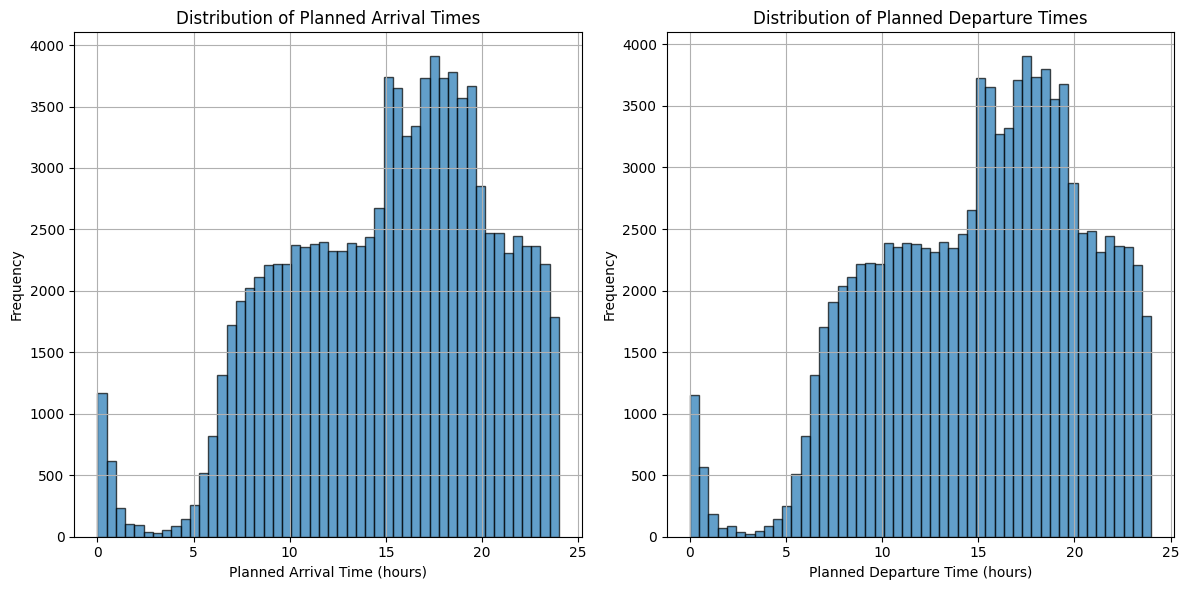

In [131]:
df['planned_arrival_hours'] = df['planned_time_arrival'].dt.hour + df['planned_time_arrival'].dt.minute / 60
df['planned_departure_hours'] = df['planned_time_departure'].dt.hour + df['planned_time_departure'].dt.minute / 60
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['planned_arrival_hours'].hist(bins=50, edgecolor='black', alpha=0.7, range=(0, 24))
plt.title('Distribution of Planned Arrival Times')
plt.xlabel('Planned Arrival Time (hours)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df['planned_departure_hours'].hist(bins=50, edgecolor='black', alpha=0.7, range=(0, 24))
plt.title('Distribution of Planned Departure Times')
plt.xlabel('Planned Departure Time (hours)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

##### A small sidenote to mention here is the similarity between the arrival and departure times. This graph shows that most trains are active between 3 p.m. and 8 p.m. and since the graphs don't change much between arrival and departure, a conclusion could be made that most stops at a station are short. We can confirm this by running some calculations to find the average length spent between arriving at a platform and departing from said platform.

In [132]:
df['time_spent_at_platforms'] = (df['working_time_departure'] - df['working_time_arrival']).dt.total_seconds()
average_duration = df['time_spent_at_platforms'].mean()
print(f"The average time spent at a platform is: {average_duration:.2f} seconds.")

The average time spent at a platform is: 28.52 seconds.


#### Next we wanted to see how many stops occur on each route, on average.

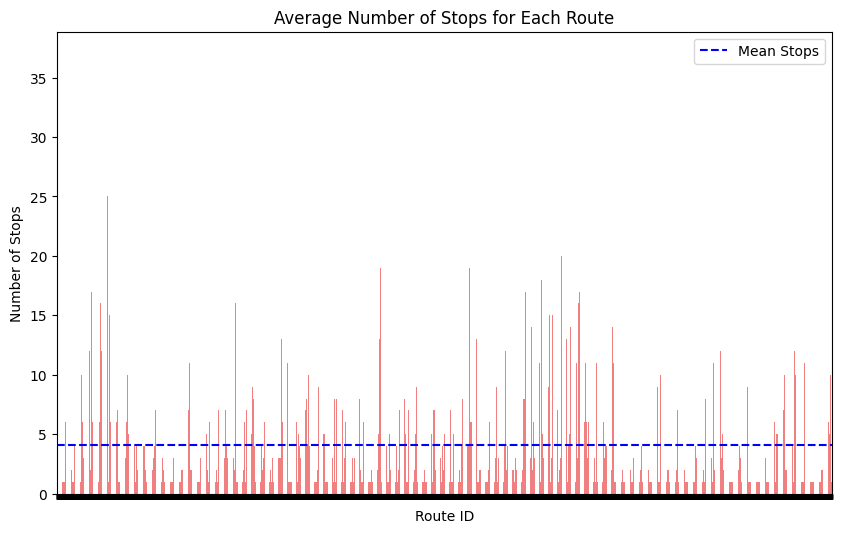

In [133]:
mean_stops_per_route = df.groupby('route_id').size().mean()
plt.figure(figsize=(10, 6))
ax = df.groupby('route_id').size().plot(kind='bar', color='lightcoral')
ax.set_xticklabels(['' for _ in range(len(df['route_id'].unique()))])

plt.axhline(y=mean_stops_per_route, color='blue', linestyle='--', label='Mean Stops')
plt.title('Average Number of Stops for Each Route')
plt.xlabel('Route ID')
plt.ylabel('Number of Stops')
plt.legend()
plt.show()        

# Next, we wanted to find out how many stops are delayed on average and break that down into delayed arrivals versus delayed departures.

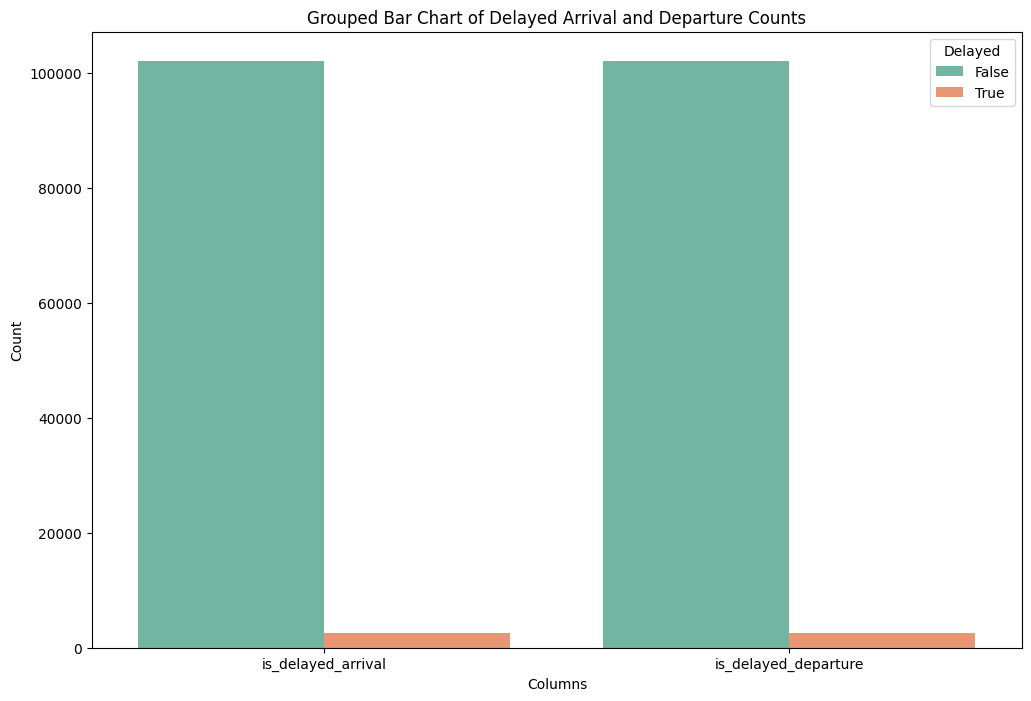

In [134]:
melted_df = pd.melt(df[['is_delayed_arrival', 'is_delayed_departure']], var_name='Columns', value_name='is_delayed')

plt.figure(figsize=(12, 8))
sns.countplot(data=melted_df, x='Columns', hue='is_delayed', palette="Set2", order=['is_delayed_arrival', 'is_delayed_departure'])

plt.xlabel("Columns")
plt.ylabel("Count")
plt.title("Grouped Bar Chart of Delayed Arrival and Departure Counts")

plt.legend(title='Delayed', loc='upper right', labels=['False', 'True'])

plt.show()

In [135]:
arrival_percentage = (df['is_delayed_arrival'].value_counts(normalize=True) * 100).round(2)
departure_percentage = (df['is_delayed_departure'].value_counts(normalize=True) * 100).round(2)

print("Percentage of Delayed Arrivals:")
print(arrival_percentage)

print("\nPercentage of Delayed Departures:")
print(departure_percentage)

Percentage of Delayed Arrivals:
is_delayed_arrival
False    97.62
True      2.38
Name: proportion, dtype: float64

Percentage of Delayed Departures:
is_delayed_departure
False    97.54
True      2.46
Name: proportion, dtype: float64


#### This is impressive! This shows that of the over 100,000 stops contained in the data set, only ~2.4% were late. 

## These next two graphs show us show us the stations and routes that have the most delays. 

C:\Users\fastb\AppData\Local\Temp\ipykernel_17376\2768021794.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_platforms.index, y=top_10_platforms.values, palette='viridis')


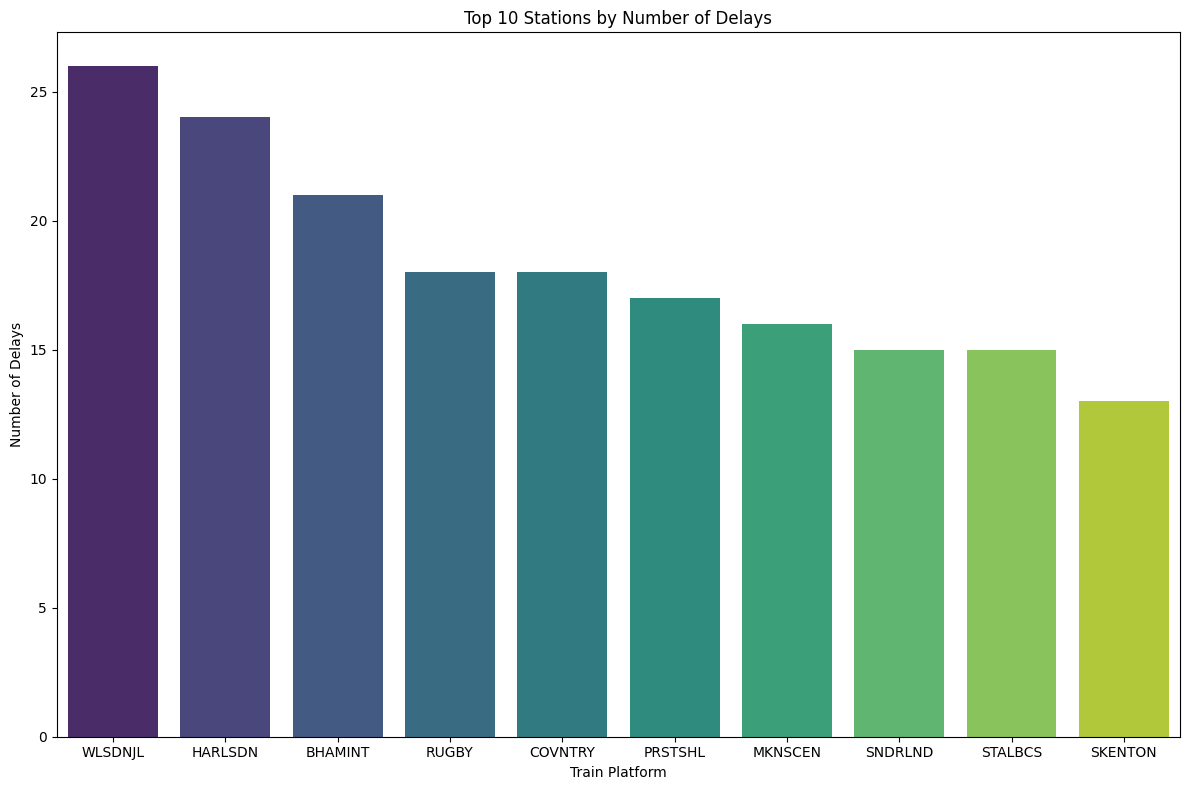

In [136]:
result = df.groupby('train_platform')['is_delayed_arrival'].sum().sort_values(ascending=False)

top_10_platforms = result.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_platforms.index, y=top_10_platforms.values, palette='viridis')
plt.title('Top 10 Stations by Number of Delays')
plt.xlabel('Train Platform')
plt.ylabel('Number of Delays')
plt.tight_layout()
plt.show()

#### The station 'WLSDNJL' is the city of Woolston, a port city for the greater Southampton area. A possible reason for its number of delays, due to trains being loaded with cargo from the boats.

C:\Users\fastb\AppData\Local\Temp\ipykernel_17376\3424772990.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_routes.index, y=top_10_routes.values, palette='viridis')


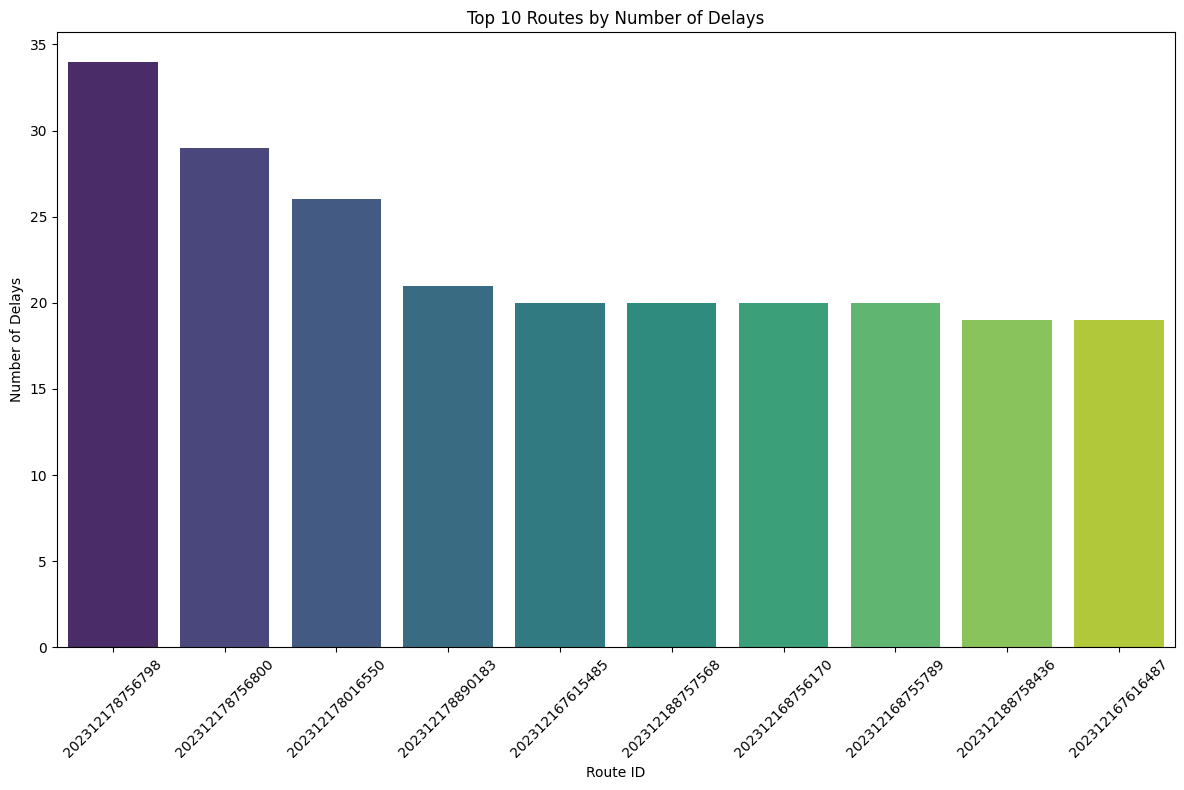

In [137]:
result = df.groupby('route_id')['is_delayed_arrival'].sum().sort_values(ascending=False)

top_10_routes = result.head(10)

# Convert 'route_id' to string for proper descending order
top_10_routes.index = top_10_routes.index.astype(str)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_routes.index, y=top_10_routes.values, palette='viridis')
plt.title('Top 10 Routes by Number of Delays')
plt.xlabel('Route ID')
plt.ylabel('Number of Delays')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [138]:
df.groupby('route_id').agg({
    'is_delayed_arrival': 'sum',
    'train_platform': lambda x: list(x)
}).sort_values(by='is_delayed_arrival', ascending=False).head(10)

,is_delayed_arrival,train_platform
route_id,,
202312178756798,34,"[CRGDRN, CDRS, DLREOCH, DMBRTNC, DMBRTNE, DALM..."
202312178756800,29,"[BTHGATE, LVNSTNN, HAYMRKT, BLKRDGE, SINGER, C..."
202312178016550,26,"[HOVE, ALDTON, PSLDAWH, FSHRSGT, STHWICK, SHRH..."
202312178890183,21,"[PRSP, HASOCKS, BURGESH, WVLSFLD, HYWRDSH, BAL..."
202312167615485,20,"[SWNWICK, FAREHAM, COSHAM, HAVANT, EMSWTH, CHC..."
202312188757568,20,"[JORDANH, HYNDLND, PTCK, CHRNGXG, GLGQLL, GLGH..."
202312168756170,20,"[AIRBLES, HAMLTNC, HAMLTNW, BLANTYR, NWTL, CMB..."
202312168755789,20,"[CLYBANK, YOKER, GSCD, SCTSTNH, JORDANH, HYNDL..."
202312188758436,19,"[KRKWOOD, BRGDDIE, BALISTN, MNTVRNN, CARMYLE, ..."


In [139]:
route_of_interest = '202312178756798'
station_of_interest = 'WLSDNJL'

total_routes = df['route_id'].nunique()
print(f"There are {total_routes} total routes.")

station_of_interest = 'WLSDNJL'
routes_with_station = df[df['train_platform'] == station_of_interest]
num_routes_with_station = routes_with_station['route_id'].nunique()
print(f"The station {station_of_interest} is present in {num_routes_with_station} routes.")

percentage_routes_with_station = (num_routes_with_station / total_routes) * 100
print(f"The station {station_of_interest} is present in {percentage_routes_with_station:.2f}% of total routes.")

station_in_route = df[(df['route_id'] == route_of_interest) & (df['update_origin'] == station_of_interest)].shape[0] > 0

if station_in_route:
    print(f"The station {station_of_interest} is present in route {route_of_interest}.")
else:
    print(f"The station {station_of_interest} is not present in route {route_of_interest}.")

There are 25661 total routes.
The station WLSDNJL is present in 189 routes.
The station WLSDNJL is present in 0.74% of total routes.
The station WLSDNJL is not present in route 202312178756798.


#### Well, this shows that Woolston is not as busy as we thought. based on this data, Woolston is in less than 1% of the total routes recorded in the data. This implies that Woolston stop may suffer with infrastructure issues or that a lot of trains coming into Woolston are delayed already. Furthermore, since we can see that this stop is not included in the route with the most delays, we can see that it might not be a route-specific issue.

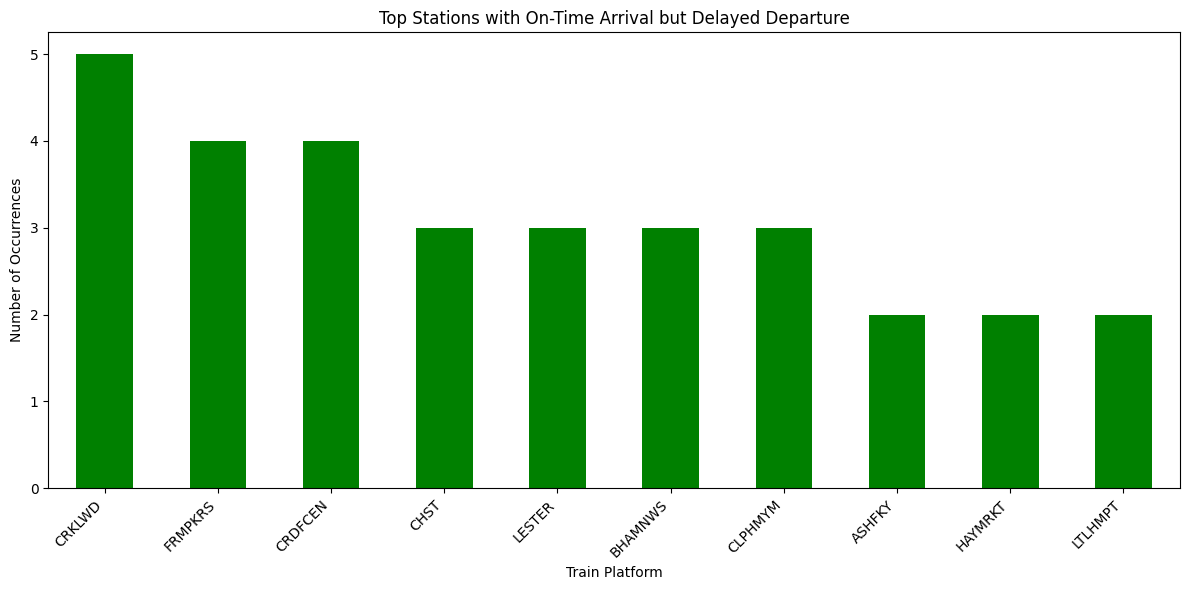

In [140]:
on_time_arrival_delayed_departure = df[(df['is_delayed_arrival'] == False) & (df['is_delayed_departure'] == True)]
station_counts = on_time_arrival_delayed_departure.groupby('train_platform').size()
sorted_stations = station_counts.sort_values(ascending=False)
top_stations = sorted_stations.head(10)

plt.figure(figsize=(12, 6))
top_stations.plot(kind='bar', color='green')
plt.title('Top Stations with On-Time Arrival but Delayed Departure')
plt.xlabel('Train Platform')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### The data here shows that 'CRKLWD' or Cricklewood Railway Station, has the most delayed departures of the stations in the dataset when the incoming train is on time. Although there are few occurences, this could mean that CRKLWD has some issues with processing incoming trains and having them depart on time. There could be many reasons for this, but we can not diagnose the reasons for these delays with our dataset. To find the root of those disruptions that would be on UK Rail officials to launch an investigation into.

In [141]:
on_time_arrivals = df[df['is_delayed_arrival'] == False]
delay_percentage = (on_time_arrivals.groupby('train_platform')['is_delayed_departure'].sum() / on_time_arrivals.groupby('train_platform').size()) * 100
non_zero_data = delay_percentage[delay_percentage != 0]

# Calculate the first and third quartiles (Q1 and Q3)
Q1 = non_zero_data.quantile(0.25)
Q3 = non_zero_data.quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the upper bound for outliers
upper_bound = Q3 + 1.5 * IQR
upper_bound

6.92304270046438

C:\Users\fastb\AppData\Local\Temp\ipykernel_17376\13024187.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=sorted_filtered_results.index, x=sorted_filtered_results.values, palette="flare")
C:\Users\fastb\AppData\Local\Temp\ipykernel_17376\13024187.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), size=8)


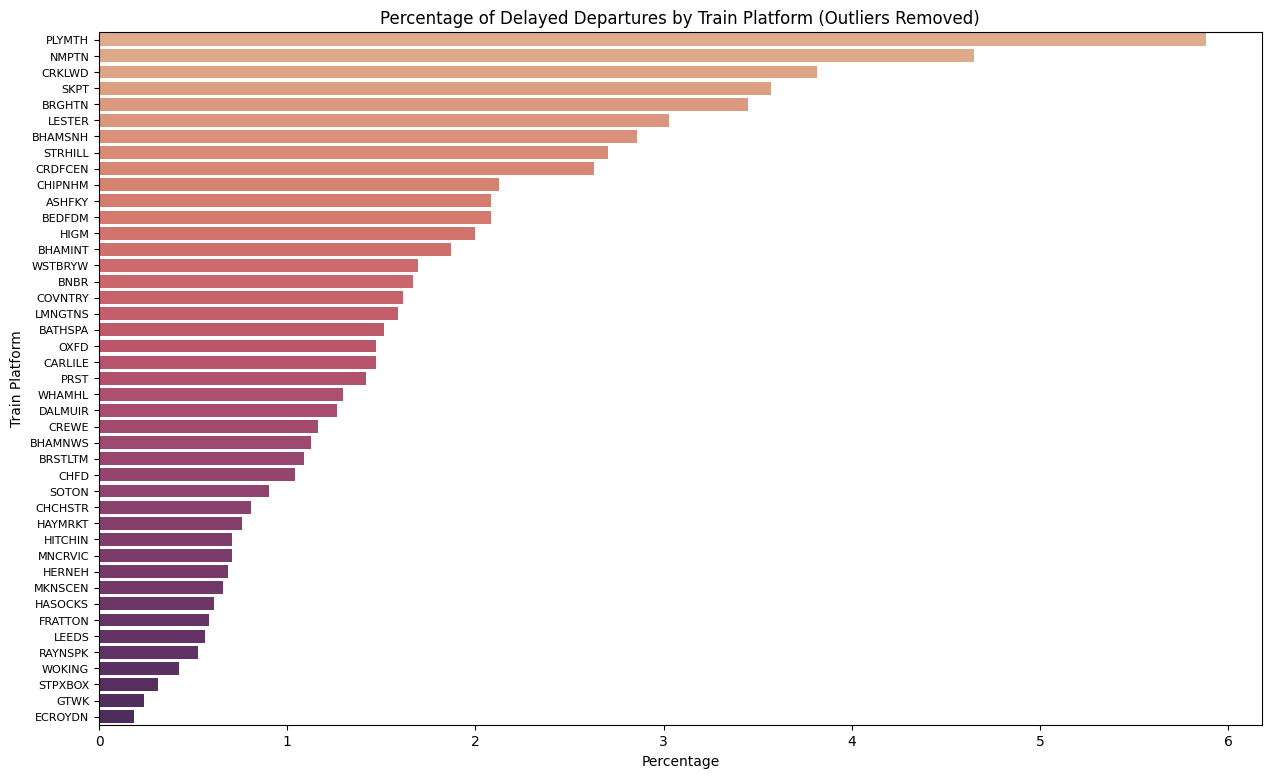

In [142]:
# Ensuring data is within bounds, sorts for nice graph
filtered_results = delay_percentage[(delay_percentage > 0) & (delay_percentage <= upper_bound)]
sorted_filtered_results = filtered_results.sort_values(ascending=False)

plt.figure(figsize=(15, 9))
ax = sns.barplot(y=sorted_filtered_results.index, x=sorted_filtered_results.values, palette="flare")
plt.title('Percentage of Delayed Departures by Train Platform (Outliers Removed)')
plt.ylabel('Train Platform')
plt.xlabel('Percentage')

# Adjusting y-axis label spacing
ax.set_yticklabels(ax.get_yticklabels(), size=8)

plt.show()


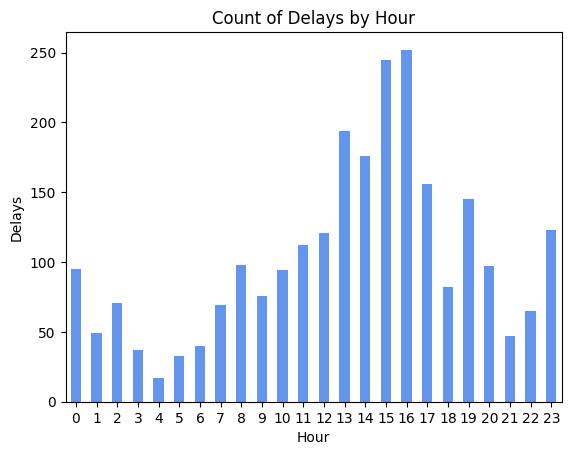

In [143]:
df['hour'] = df['working_time_arrival'].dt.hour

hourly_count = df.groupby('hour')['is_delayed_arrival'].sum()

hourly_count.plot(kind='bar', color='cornflowerblue')
plt.title('Count of Delays by Hour')
plt.xlabel('Hour')
plt.ylabel('Delays')
plt.xticks(rotation=0)
plt.show()

#### This gives us a bit more insight into these delays. We can see that Cricklewood is still near the top of the delay chart when it comes to percentage of delays occuring when the train arrival is on-time. However, PLYMTH has by far the highest proportion of caused delays. In the last graph, we can see that count of delays per hour loosely follows the shape of the first graph that showed the count of stops by the hour. So as the railways get busier, delays are more pertinent.

## Part 3: Conclusion and Findings

The concluding section encapsulates our key findings and offers a comprehensive explanation. This is where we tie together the insights gained from our analysis and present a nuanced understanding of the timely nature of the UK Rail system.

#### Questions Explored:

1. Dive into the scheduled train arrivals and departures.
2. Visualize the distribution of scheduled times.
3. Determine the average number of stops a route makes.
4. Identify routes and stations with the most inconsistent schedules.
5. Explore the frequency and duration of delays.
6. Uncover the stations that most frequently cause delays.
7. Analyze the time of day with the most delays.

## Conclusion

The analysis reveals that the UK Rail system generally operates on time, with only a small percentage of delays. Woolston stands out with the most delays, possibly influenced by infrastructure or operational challenges. However, you are more likely to encounter a delay in the Plymouth Railway Station if you are arriving there on-time. The data also suggests that delays are more prevalent during peak hours, emphasizing the importance of considering time-specific factors in railway operations. Furthermore, since most stops are made during the day time this could suggest that the trains we looked at were passenger trains since freight trains often run at night.